# Project Data Lake

### Setup dan Konfigurasi

#### Import library

In [47]:
import pandas as pd
from sqlalchemy import create_engine, text
import os
import shutil
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import PyPDF2
from textblob import TextBlob
import random


#### Konfigurasi Koneksi Database

Konfigurasi koneksi ke database PostgreSQL

In [48]:
db_user = 'postgres'
db_password = 'ardiwinata230803'
db_host = 'localhost'
db_port = '5432'

Koneksi ke DB Staging Area (adventureworks_st)

In [49]:
db_name_st = 'adventureworks_st'
connection_string_st = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_st}"
engine_st = create_engine(connection_string_st)
print(f"✅ Koneksi ke database Staging Area ('{db_name_st}') berhasil!")

✅ Koneksi ke database Staging Area ('adventureworks_st') berhasil!


Koneksi ke DB Data Warehouse (adventureworks_wh)

In [50]:
db_name_wh = 'adventureworks_wh'
connection_string_wh = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_wh}"
engine_wh = create_engine(connection_string_wh)
print(f"✅ Koneksi ke database Data Warehouse ('{db_name_wh}') berhasil!")

✅ Koneksi ke database Data Warehouse ('adventureworks_wh') berhasil!


#### Konfigurasi Path Folder

In [51]:
ORGANIZED_PATH = 'data_organized'
RAW_DATA_PATH = 'data_raw'
OUTPUT_PATH = 'output'

print("✅ Semua path folder berhasil dikonfigurasi.")

✅ Semua path folder berhasil dikonfigurasi.


#### Definisi Nama Kolom untuk Data Raw

Ini penting untuk membaca file CSV yang tidak memiliki header

In [52]:
pelanggan_cols = ['id_pelanggan', 'nama_depan', 'nama_belakang', 'email', 'kota_asal']
produk_cols = ['id_produk', 'nama_produk', 'subkategori', 'kategori', 'harga_standar', 'warna', 'lini_produk']
penjualan_cols = ['id_order', 'id_order_detail', 'tanggal_order', 'id_pelanggan', 'id_produk', 'jumlah_barang', 'harga_satuan', 'total_harga']

#### Status Konfigurasi

In [53]:
print("✅ Setup dan Konfigurasi Selesai.")

✅ Setup dan Konfigurasi Selesai.


### Kumpulan Fungsi ETL

Sortir file dalam folder

In [54]:
def sortir_file_mentah():
    """Memindahkan file dari landing zone ke folder terorganisir berdasarkan tipe."""
    print("\n--- Memulai Proses Sortir File Mentah ---")
    
    # Definisikan path sumber dan tujuan
    source_path = 'data_raw'
    organized_base = 'data_organized'
    
    paths = {
        '.csv': os.path.join(organized_base, 'csv'),
        '.pdf': os.path.join(organized_base, 'pdf'),
        '.txt': os.path.join(organized_base, 'txt')
    }

    # Pastikan semua folder tujuan ada
    for path in paths.values():
        os.makedirs(path, exist_ok=True)
        
    # Pindahkan file
    files_to_move = os.listdir(source_path)
    if not files_to_move:
        print("-> Folder data_landing kosong, tidak ada file yang disortir.")
        return
        
    for filename in files_to_move:
        file_path = os.path.join(source_path, filename)
        _, ext = os.path.splitext(filename)
        ext = ext.lower()

        if ext in paths:
            # Kita pakai shutil.copy biar file asli tetap ada di landing zone sebagai backup
            shutil.copy(file_path, os.path.join(paths[ext], filename))
            print(f"  -> File '{filename}' disalin ke '{paths[ext]}'")
        else:
            print(f"  -> File '{filename}' tidak dikenali tipenya, dilewati.")
            
    print("✅ Proses Sortir File Selesai.")

Kode fungsi reset

In [55]:
def reset_all_tables_dwh_staging():
    """Mengosongkan semua tabel di Data Warehouse Inti (adventureworks_st) sebelum diisi ulang."""
    print("\n--- MERESET SEMUA TABEL DI DATA WAREHOUSE INTI (adventureworks_st) ---")
    with engine_st.connect() as connection:
        # TRUNCATE dengan CASCADE untuk memastikan penghapusan berantai dan menghindari masalah foreign key
        try:
            connection.execute(text('TRUNCATE TABLE "Fakta_Penjualan" CASCADE;'))
            connection.execute(text('TRUNCATE TABLE "Dim_Pelanggan" CASCADE;'))
            connection.execute(text('TRUNCATE TABLE "Dim_Produk" CASCADE;'))
            connection.execute(text('TRUNCATE TABLE "Dim_Lokasi" CASCADE;'))
            connection.execute(text('TRUNCATE TABLE "Dim_Waktu" CASCADE;'))
            connection.commit()
            print("✅ Semua tabel di adventureworks_st berhasil dikosongkan.")
        except Exception as e:
            print(f"⚠️ Gagal mereset tabel (mungkin tabel belum ada, ini normal pada eksekusi pertama): {e}")
            print("Melanjutkan proses... (Pastikan tabel sudah dibuat jika ini bukan eksekusi pertama)")

Kode fungsu etl pelanggan

In [56]:
def etl_dim_pelanggan_scd2():
    print("\n--- Memulai ETL SCD Tipe 2 untuk Dim_Pelanggan ---")
    
    # E: Extract (Ingest data mentah pelanggan dari CSV)
    source_df = pd.read_csv(os.path.join('data_organized', 'csv', 'raw_pelanggan.csv'), sep=',', header=None, skiprows=1, names=pelanggan_cols)
    # T: Transform (Pembentukan nama lengkap)
    source_df['nama_lengkap'] = source_df['nama_depan'] + ' ' + source_df['nama_belakang']

    try:
        # Extract: Baca data pelanggan aktif dari DWH (status_sekarang = TRUE)
        dwh_df = pd.read_sql_query('SELECT * FROM "Dim_Pelanggan" WHERE status_sekarang = TRUE', engine_st)
    except Exception as e:
        # Handle jika tabel kosong atau belum ada
        print(f"Info: Tabel Dim_Pelanggan_lama kosong atau belum ada ({e}). Membuat DataFrame kosong.")
        dwh_df = pd.DataFrame(columns=['pelanggan_key', 'id_pelanggan', 'nama_lengkap', 'email', 'kota_asal', 'tanggal_mulai', 'tanggal_akhir', 'status_sekarang'])
        
    # T: Transform (Deteksi perubahan dan pembentukan record baru/expired)
    merged_df = pd.merge(source_df, dwh_df, on='id_pelanggan', how='left', suffixes=('_new', '_old'), indicator=True)

    new_records = merged_df[merged_df['_merge'] == 'left_only'].copy()
    new_to_insert = new_records[['id_pelanggan', 'nama_lengkap_new', 'email_new', 'kota_asal_new']].copy()
    new_to_insert.rename(columns={'nama_lengkap_new': 'nama_lengkap', 'email_new': 'email', 'kota_asal_new': 'kota_asal'}, inplace=True)
    new_to_insert['tanggal_mulai'] = date.today()
    new_to_insert['tanggal_akhir'] = '9999-12-31'
    new_to_insert['status_sekarang'] = True

    changed_df = merged_df[merged_df['_merge'] == 'both'].copy()
    changed_df = changed_df[changed_df['kota_asal_new'] != changed_df['kota_asal_old']]
    
    keys_to_expire = changed_df['pelanggan_key'].astype(int).tolist() if not changed_df.empty else []

    updates_as_new = changed_df[['id_pelanggan', 'nama_lengkap_new', 'email_new', 'kota_asal_new']].copy()
    updates_as_new.rename(columns={'nama_lengkap_new': 'nama_lengkap', 'email_new': 'email', 'kota_asal_new': 'kota_asal'}, inplace=True)
    updates_as_new['tanggal_mulai'] = date.today()
    updates_as_new['tanggal_akhir'] = '9999-12-31'
    updates_as_new['status_sekarang'] = True

    records_to_insert = pd.concat([new_to_insert, updates_as_new], ignore_index=True)

    # L: Load (Muat data ke Dim_Pelanggan di adventureworks_st)
    with engine_st.connect() as connection:
        if keys_to_expire:
            print(f"[L] Mengeksekusi UPDATE untuk {len(keys_to_expire)} record yang berubah (expire).")
            connection.execute(text(f"""
                UPDATE "Dim_Pelanggan"
                SET status_sekarang = FALSE, tanggal_akhir = '{date.today()}'
                WHERE pelanggan_key IN ({','.join(map(str, keys_to_expire))})
            """))
            connection.commit()
        
        if not records_to_insert.empty:
            print(f"[L] Mengeksekusi INSERT untuk {len(records_to_insert)} record baru/berubah.")
            records_to_insert.to_sql('Dim_Pelanggan', engine_st, if_exists='append', index=False, chunksize=1000)
        else:
            print("[L] Tidak ada record baru atau perubahan untuk di-INSERT.")
            
    print(f"✅ SUKSES! Proses SCD Tipe 2 untuk Dim_Pelanggan selesai. ({len(records_to_insert)} inserted, {len(keys_to_expire)} expired)")

Kode fungsi etl produk

In [57]:
def etl_dim_produk():
    print("\n--- Memulai ETL Dim_Produk ---")
    # E: Extract (Ingest data mentah produk dari CSV)
    df = pd.read_csv(os.path.join('data_organized', 'csv', 'raw_produk.csv'), sep=',', header=None, skiprows=1, names=produk_cols)
    
    # T: Transform (Mengisi nilai kosong di kolom 'warna')
    df['warna'].fillna('Tidak Berwarna', inplace=True)
    
    # L: Load (Muat data ke Dim_Produk di adventureworks_st)
    df.to_sql('Dim_Produk', engine_st, if_exists='append', index=False, chunksize=1000)
    print(f"✅ SUKSES! {len(df)} baris dimuat ke Dim_Produk.")

Kode fungsi etl lokasi

In [58]:
def etl_dim_lokasi():
    print("\n--- Memulai ETL Dim_Lokasi ---")
    # E: Extract (Ingest data mentah pelanggan dari CSV untuk mendapatkan kota_asal)
    df = pd.read_csv(os.path.join('data_organized', 'csv', 'raw_pelanggan.csv'), sep=',', header=None, skiprows=1, names=pelanggan_cols)
    
    # T: Transform (Mengambil nilai unik dari kolom 'kota_asal' dan buang nilai NaN)
    df_final = pd.DataFrame(df['kota_asal'].unique(), columns=['nama_kota']).dropna()
    
    # L: Load (Muat data ke Dim_Lokasi di adventureworks_st)
    df_final.to_sql('Dim_Lokasi', engine_st, if_exists='append', index=False, chunksize=1000)
    print(f"✅ SUKSES! {len(df_final)} baris dimuat ke Dim_Lokasi.")

Kode fungsi etl waktu

In [59]:
def etl_dim_waktu():
    print("\n--- Memulai ETL Dim_Waktu ---")
    # E: Extract (Ingest data mentah penjualan dari CSV untuk mendapatkan rentang tanggal)
    df = pd.read_csv(os.path.join('data_organized', 'csv', 'raw_penjualan.csv'), sep=',', header=None, skiprows=1, names=penjualan_cols)
    df['tanggal_order'] = pd.to_datetime(df['tanggal_order'])
    
    # T: Transform (Membuat rentang tanggal unik dan atribut waktu)
    date_range = pd.date_range(df['tanggal_order'].min(), df['tanggal_order'].max(), freq='D')
    df_final = pd.DataFrame(date_range, columns=['tanggal'])
    
    df_final['id_waktu'] = df_final['tanggal'].dt.strftime('%Y%m%d').astype(int)
    df_final['tahun'] = df_final['tanggal'].dt.year
    df_final['kuartal'] = df_final['tanggal'].dt.quarter
    df_final['bulan'] = df_final['tanggal'].dt.month
    df_final['nama_bulan'] = df_final['tanggal'].dt.strftime('%B')
    df_final['hari'] = df_final['tanggal'].dt.day
    df_final['nama_hari'] = df_final['tanggal'].dt.strftime('%A')
    
    # L: Load (Muat data ke Dim_Waktu di adventureworks_st)
    df_final.to_sql('Dim_Waktu', engine_st, if_exists='append', index=False, chunksize=1000)
    print(f"✅ SUKSES! {len(df_final)} baris dimuat ke Dim_Waktu.")

Kode fungsi etl pdf

In [60]:
def etl_pdf_to_staging():
    print("\n--- Memulai ETL untuk file PDF ---")
    
    # Tentukan path folder PDF
    pdf_folder = os.path.join('data_organized', 'pdf')
    
    # List kosong untuk menampung hasil ekstraksi
    hasil_ekstraksi = []
    
    try:
        # Loop melalui semua file di dalam folder pdf
        for filename in os.listdir(pdf_folder):
            if filename.lower().endswith('.pdf'):
                print(f"  -> Memproses file: {filename}...")
                file_path = os.path.join(pdf_folder, filename)
                
                text = ""
                # Buka dan baca file PDF
                with open(file_path, 'rb') as file:
                    reader = PyPDF2.PdfReader(file)
                    for page in reader.pages:
                        text += page.extract_text() + "\n" # Tambah baris baru antar halaman
                
                # Tambahkan hasil ke list
                hasil_ekstraksi.append({
                    'nama_file': filename,
                    'isi_teks': text
                })
        
        if not hasil_ekstraksi:
            print("⚠️ Tidak ada file PDF yang ditemukan untuk diproses.")
            return

        # Transformasi: Ubah list menjadi DataFrame dan tambahkan timestamp
        df_pdf = pd.DataFrame(hasil_ekstraksi)
        df_pdf['tgl_ekstrak'] = datetime.now()
        
        # Load: Masukkan data ke tabel stg_dokumen_pdf
        target_table_name = 'stg_dokumen_pdf'
        print(f"   -> Memuat {len(df_pdf)} dokumen ke tabel '{target_table_name}'...")
        
        # Kita pakai 'replace' untuk staging, agar setiap run hasilnya fresh
        df_pdf.to_sql(target_table_name, engine_st, if_exists='replace', index=False)

        print(f"✅ SUKSES! ETL untuk PDF selesai.")

    except Exception as e:
        print(f"❌ GAGAL! Terjadi error saat proses ETL PDF: {e}")

Kode fungsi etl txt

In [61]:
def etl_txt_to_staging():
    print("\n--- Memulai ETL TXT dengan ID Pelanggan ---")
    
    txt_folder = os.path.join('data_organized', 'txt')
    hasil_analisis = []
    
    try:
        # Langkah Baru 1: Ambil daftar ID pelanggan asli dari DWH
        print("  -> Mengambil daftar ID pelanggan dari Dim_Pelanggan...")
        list_id_pelanggan = pd.read_sql_query('SELECT id_pelanggan FROM "Dim_Pelanggan"', engine_st)['id_pelanggan'].tolist()
        
        if not list_id_pelanggan:
            print("⚠️ GAGAL! Tidak ada data pelanggan di Dim_Pelanggan untuk dijadikan referensi.")
            return

        print(f"  -> Ditemukan {len(list_id_pelanggan)} ID pelanggan.")

        # Loop melalui file TXT
        for filename in os.listdir(txt_folder):
            if filename.lower().endswith('.txt'):
                print(f"  -> Menganalisis file: {filename}...")
                file_path = os.path.join(txt_folder, filename)
                
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read()
                
                blob = TextBlob(text)
                
                # Langkah Baru 2: Pilih ID pelanggan secara acak dan tempelkan
                random_customer_id = random.choice(list_id_pelanggan)
                
                hasil_analisis.append({
                    'id_pelanggan': random_customer_id, # <-- KOLOM BARU
                    'nama_file': filename,
                    'isi_tweet': text,
                    'polarity': blob.sentiment.polarity,
                    'subjectivity': blob.sentiment.subjectivity
                })
        
        # ... (Sisa prosesnya sama)
        df_txt = pd.DataFrame(hasil_analisis)
        df_txt['tgl_ekstrak'] = datetime.now()
        
        target_table_name = 'stg_analisis_sentimen'
        
        # Kita perlu pastikan tabelnya bisa menampung kolom baru
        # Cara paling aman adalah dengan 'replace' karena ini tabel staging
        print(f"   -> Memuat {len(df_txt)} hasil analisis ke tabel '{target_table_name}'...")
        df_txt.to_sql(target_table_name, engine_st, if_exists='replace', index=False)

        print(f"✅ SUKSES! ETL untuk TXT dengan ID pelanggan selesai.")

    except Exception as e:
        print(f"❌ GAGAL! Terjadi error saat proses ETL TXT: {e}")

Kode fungsi etl fakta

In [62]:
# Di dalam [CELL 2] - Kumpulan Fungsi ETL
# Ganti fungsi etl_fakta_penjualan yang lama dengan ini:

def etl_fakta_penjualan():
    print("\n--- Memulai ETL FINAL Fakta_Penjualan (dengan Surrogate Key Lookup) ---")
    
    try:
        # --- EXTRACT ---
        print("   -> [E] Mengekstrak data penjualan mentah, Dim_Pelanggan, dan Dim_Lokasi...")
        # Baca data penjualan mentah
        df_penjualan = pd.read_csv(os.path.join(RAW_DATA_PATH, 'raw_penjualan.csv'), sep=',', header=None, skiprows=1, names=penjualan_cols)
        
        # Baca tabel dimensi yang sudah jadi dari DWH untuk lookup
        df_dim_pelanggan = pd.read_sql_table('Dim_Pelanggan', engine_st)
        df_dim_lokasi = pd.read_sql_table('Dim_Lokasi', engine_st)
        print("      -> Data sumber berhasil dibaca.")

        # --- TRANSFORM ---
        print("   -> [T] Melakukan transformasi dan lookup surrogate key...")
        
        # 1. Konversi tipe data tanggal agar bisa dibandingkan
        df_penjualan['tanggal_order'] = pd.to_datetime(df_penjualan['tanggal_order'])
        df_dim_pelanggan['tanggal_mulai'] = pd.to_datetime(df_dim_pelanggan['tanggal_mulai'])
        df_dim_pelanggan['tanggal_akhir'] = pd.to_datetime(df_dim_pelanggan['tanggal_akhir'])
        df_penjualan['id_waktu'] = df_penjualan['tanggal_order'].dt.strftime('%Y%m%d').astype(int)

        # 2. Lakukan penggabungan (merge) antara data penjualan dan SEMUA riwayat pelanggan
        # Ini akan membuat setiap penjualan terhubung dengan semua kemungkinan versi historis pelanggannya
        df_merged = pd.merge(df_penjualan, df_dim_pelanggan, on='id_pelanggan', how='left')
        
        # 3. Filter untuk mendapatkan record dimensi yang TEPAT (yang aktif saat transaksi terjadi)
        # Ini adalah logika inti dari lookup ke dimensi SCD Tipe 2
        df_valid_facts = df_merged[
            (df_merged['tanggal_order'] >= df_merged['tanggal_mulai']) & 
            (df_merged['tanggal_order'] <= df_merged['tanggal_akhir'])
        ].copy()
        print("      -> Berhasil menemukan pelanggan_key yang sesuai untuk setiap transaksi.")

        # 4. Lakukan join dengan Dim_Lokasi untuk mendapatkan id_lokasi
        df_final = pd.merge(df_valid_facts, df_dim_lokasi, left_on='kota_asal', right_on='nama_kota', how='left')
        
        # 5. Pilih kolom final sesuai struktur tabel baru
        kolom_final = [
            'id_order_detail', 
            'id_order', 
            'pelanggan_key', # <-- MENGGUNAKAN surrogate key
            'id_produk', 
            'id_waktu', 
            'id_lokasi', 
            'jumlah_barang', 
            'harga_satuan', 
            'total_harga'
        ]
        df_final = df_final[kolom_final]

        # 6. Jaring pengaman terakhir untuk duplikasi
        df_final.drop_duplicates(subset=['id_order_detail'], keep='first', inplace=True)

        # --- LOAD ---
        print(f"   -> [L] Memuat {len(df_final)} baris data ke Fakta_Penjualan...")
        df_final.to_sql('Fakta_Penjualan', engine_st, if_exists='append', index=False, chunksize=1000)
        
        print("\n✅ Proses ETL untuk Fakta_Penjualan selesai! Relasi seharusnya sudah sempurna.")

    except Exception as e:
        print(f"❌ GAGAL! Terjadi error saat ETL Fakta Penjualan: {e}")

#### Status Fungsi ETL

In [63]:
print("✅ Semua fungsi ETL berhasil didefinisikan.")

✅ Semua fungsi ETL berhasil didefinisikan.


### Eksekusi Pipeline Utama

In [ ]:
try:
    print("\n\n===== MEMULAI PIPELINE ETL LENGKAP =====")
    
    # 0. Sortir file mentah
    sortir_file_mentah()
    
    # 1. Kosongkan semua tabel DWH
    reset_all_tables_dwh_staging()
    
    # 2. Bangun Dimensi Utama dulu
    etl_dim_produk()
    etl_dim_waktu()
    # PENTING: Pelanggan dijalankan dulu karena jadi referensi untuk lokasi dan txt
    etl_dim_pelanggan_scd2() 
    etl_dim_lokasi()

    # 3. Proses data tidak terstruktur ke staging
    etl_pdf_to_staging()
    etl_txt_to_staging()

    # 4. Bangun Tabel Fakta (setelah semua dimensi siap)
    etl_fakta_penjualan()
    
    print("\n\n===== PIPELINE ETL SELESAI DENGAN SUKSES! =====")

except Exception as e:
    print(f"\n❌ GAGAL! Error saat eksekusi pipeline: {e}")



===== MEMULAI PIPELINE ETL LENGKAP =====

--- Memulai Proses Sortir File Mentah ---
  -> File 'Laporan Penjualan Q1 2025.pdf' disalin ke 'data_organized\pdf'
  -> File 'raw_pelanggan.csv' disalin ke 'data_organized\csv'
  -> File 'raw_penjualan.csv' disalin ke 'data_organized\csv'
  -> File 'raw_produk.csv' disalin ke 'data_organized\csv'
  -> File 'tweet-1.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-10.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-11.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-12.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-13.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-14.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-15.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-16.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-17.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-18.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-19.txt' disalin ke 'data_organized\txt'
  -> File 'tweet-2.txt' disalin

### Analyze (Analisis Data dari Data Staging Area)

#### Analisis 1: Total Penjualan per Kategori Produk

Query ini akan menghitung total penjualan untuk setiap kategori produk dari `Fakta_Penjualan` dan `Dim_Produk`

In [65]:
print("\n\n--- Memulai Analisis 1: Total Penjualan per Kategori Produk ---")
print("Menjalankan query analisis penjualan per kategori dari adventureworks_st...")

query_kategori = """
SELECT dp.kategori, SUM(fp.total_harga) AS total_penjualan
FROM "Fakta_Penjualan" fp
JOIN "Dim_Produk" dp ON fp.id_produk = dp.id_produk
GROUP BY dp.kategori
ORDER BY total_penjualan DESC;
"""
df_kategori = pd.read_sql_query(query_kategori, engine_st)
print("✅ Query berhasil dieksekusi! Hasil analisis:\n")
display(df_kategori)



--- Memulai Analisis 1: Total Penjualan per Kategori Produk ---
Menjalankan query analisis penjualan per kategori dari adventureworks_st...
✅ Query berhasil dieksekusi! Hasil analisis:



,kategori,total_penjualan


#### Analisis 2: Tren Penjualan Bulanan

Query ini akan menghitung total penjualan per bulan untuk melihat tren penjualan dari waktu ke waktu

In [66]:
print("\n\n--- Memulai Analisis 2: Tren Penjualan Bulanan ---")
print("Menjalankan query analisis tren penjualan bulanan dari adventureworks_st...")

query_tren = """
SELECT w.tahun, w.bulan, TO_DATE(w.tahun || '-' || w.bulan, 'YYYY-MM') AS periode, SUM(fp.total_harga) AS total_penjualan
FROM "Fakta_Penjualan" fp
JOIN "Dim_Waktu" w ON fp.id_waktu = w.id_waktu
GROUP BY w.tahun, w.bulan
ORDER BY w.tahun, w.bulan;
"""
df_tren = pd.read_sql_query(query_tren, engine_st)
print("✅ Query tren penjualan berhasil dieksekusi! Hasil analisis:\n")
display(df_tren)



--- Memulai Analisis 2: Tren Penjualan Bulanan ---
Menjalankan query analisis tren penjualan bulanan dari adventureworks_st...
✅ Query tren penjualan berhasil dieksekusi! Hasil analisis:



,tahun,bulan,periode,total_penjualan


#### Analisis 3: Top 10 Pelanggan dengan Total Belanja Terbanyak

Query ini akan mengidentifikasi 10 pelanggan teratas berdasarkan total belanja mereka, dengan mempertimbangkan status aktif pelanggan (pentingnya SCD Tipe 2)

In [67]:
print("\n\n--- Memulai Analisis 3: Top 10 Pelanggan ---")
print("Menjalankan query analisis top 10 pelanggan dari adventureworks_st...")

query_top_cust = """
SELECT
    p.nama_lengkap,
    SUM(fp.total_harga) AS total_belanja
FROM "Fakta_Penjualan" fp
JOIN "Dim_Pelanggan" p ON fp.id_pelanggan = p.id_pelanggan
WHERE
    p.status_sekarang = TRUE -- Penting: Hanya ambil pelanggan yang statusnya TRUE (aktif)
GROUP BY
    p.nama_lengkap
ORDER BY
    total_belanja DESC
LIMIT 10;
"""
df_top_cust = pd.read_sql_query(query_top_cust, engine_st)
print("✅ Query top 10 pelanggan berhasil dieksekusi! Hasil analisis:\n")
display(df_top_cust)



--- Memulai Analisis 3: Top 10 Pelanggan ---
Menjalankan query analisis top 10 pelanggan dari adventureworks_st...


ProgrammingError: (psycopg2.errors.UndefinedColumn) column fp.id_pelanggan does not exist
LINE 6: JOIN "Dim_Pelanggan" p ON fp.id_pelanggan = p.id_pelanggan
                                  ^
HINT:  Perhaps you meant to reference the column "p.id_pelanggan".

[SQL: 
SELECT
    p.nama_lengkap,
    SUM(fp.total_harga) AS total_belanja
FROM "Fakta_Penjualan" fp
JOIN "Dim_Pelanggan" p ON fp.id_pelanggan = p.id_pelanggan
WHERE
    p.status_sekarang = TRUE -- Penting: Hanya ambil pelanggan yang statusnya TRUE (aktif)
GROUP BY
    p.nama_lengkap
ORDER BY
    total_belanja DESC
LIMIT 10;
]
(Background on this error at: https://sqlalche.me/e/20/f405)

#### Analisis 4: Korelasi Sentimen vs Penjualan

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime
import os
print("--- Memulai Analisis Final: Korelasi Sentimen vs Penjualan ---")

query_final = """
WITH
    -- Langkah 1: Hitung total belanja untuk setiap pelanggan aktif
    BelanjaPelanggan AS (
        SELECT
            p.id_pelanggan,
            p.nama_lengkap,
            SUM(fp.total_harga) AS total_belanja
        FROM "Fakta_Penjualan" fp
        JOIN "Dim_Pelanggan" p ON fp.id_pelanggan = p.id_pelanggan
        WHERE p.status_sekarang = TRUE
        GROUP BY p.id_pelanggan, p.nama_lengkap
    ),
    -- Langkah 2: Ambil data sentimen pelanggan dari tabel staging
    SentimenPelanggan AS (
        SELECT
            id_pelanggan,
            polarity,
            isi_tweet
        FROM stg_analisis_sentimen
    )
-- Langkah 3: Gabungkan keduanya!
SELECT
    bp.nama_lengkap,
    sp.polarity,
    bp.total_belanja,
    sp.isi_tweet
FROM SentimenPelanggan sp
JOIN BelanjaPelanggan bp ON sp.id_pelanggan = bp.id_pelanggan
ORDER BY
    sp.polarity DESC, total_belanja DESC;
"""

try:
    df_final_report = pd.read_sql_query(query_final, engine_st)
    print("✅ Query analisis gabungan berhasil dieksekusi! Ini hasilnya:")
    display(df_final_report)
except Exception as e:
    print(f"❌ GAGAL! Terjadi error saat menjalankan analisis: {e}")

--- Memulai Analisis Final: Korelasi Sentimen vs Penjualan ---
✅ Query analisis gabungan berhasil dieksekusi! Ini hasilnya:


,nama_lengkap,polarity,total_belanja,isi_tweet
0,Emma Martinez,0.500000,128.9700,"🚴‍♂️ ""Baru beli sepeda dari AdventureWorks, sm..."
1,Albert Suarez,0.214286,32.2800,"""AdventureWorks itu unik, mereka jual ke retai..."
2,Jack Hayes,0.200000,85.4800,"""Customer service-nya AdventureWorks tuh yang ..."
3,Morgan Phillips,0.000000,5976.3200,"""AdventureWorks emang jagonya sepeda gunung. T..."
4,Mete Goktepe,0.000000,5362.5698,"""Quality kontrol mereka luar biasa. Udah beli ..."
5,Dustin Lal,0.000000,4175.5300,"""Wish list 2025: AdventureWorks rilis sepeda l..."
6,Alejandro Ma,0.000000,3310.4075,"\n""AdventureWorks perlu banget kolaborasi sama..."
7,Jeremiah Jones,0.000000,2332.2800,"""Kalau kalian ke store AdventureWorks, coba mi..."
8,Jaclyn Yuan,0.000000,2199.8975,"""Respect buat AdventureWorks yang berani buka ..."
9,Ethan Garcia,0.000000,1503.5782,"""Baru tahu ternyata AdventureWorks udah 20+ ta..."


### Warehouse (Membangun Data Warehouse: `adventureworks_wh`) & Visualisasi

#### Hasil Analisis 1: Penjualan per Kategori Produk

Data `df_kategori` akan dimuat ke `adventureworks_wh` dan divisualisasikan sebagai Bar Chart



--- Membangun Data Mart & Visualisasi untuk Penjualan per Kategori Produk ---
Menambahkan timestamp laporan: 2025-06-23 19:15:25.189303
Menambahkan data ringkasan baru ke tabel 'rpt_penjualan_per_kategori' di database 'adventureworks_wh'...
✅ Tabel 'rpt_penjualan_per_kategori' berhasil ditambahkan 0 baris data baru.

Membuat visualisasi (Bar Chart) dan menyimpannya ke folder 'output'...


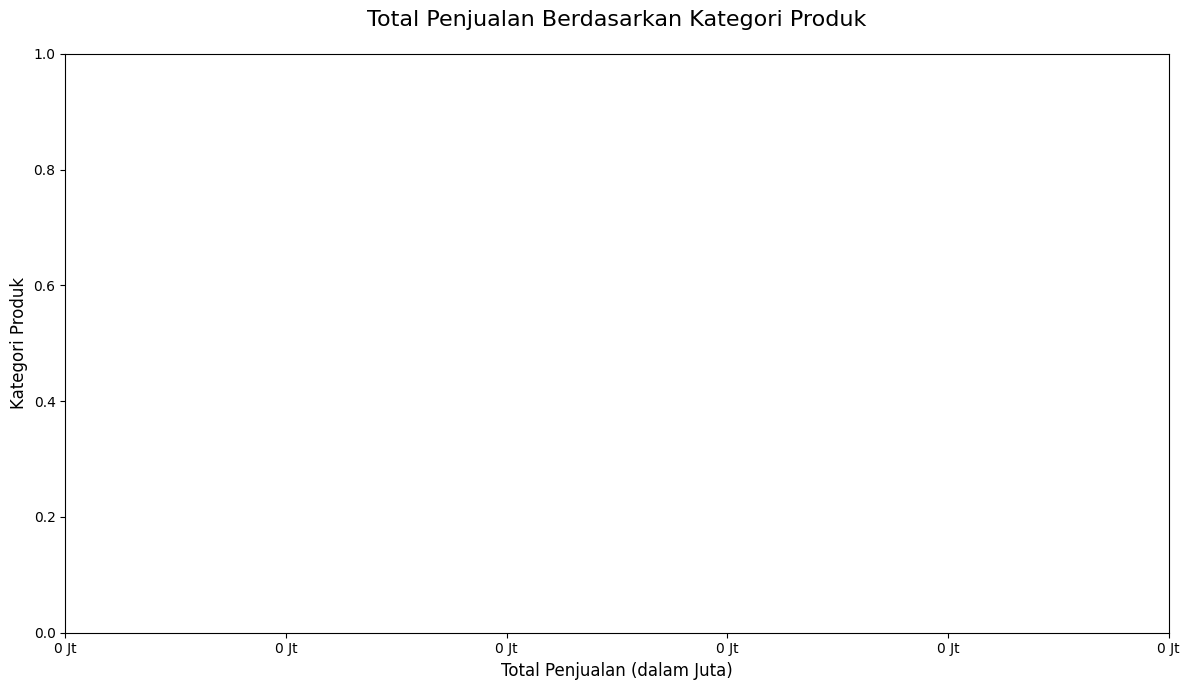

🎉 SUKSES! Grafik telah disimpan sebagai 'penjualan_per_kategori.png'.


In [68]:
print("\n\n--- Membangun Data Mart & Visualisasi untuk Penjualan per Kategori Produk ---")

# Transformasi: Tambahkan timestamp laporan
waktu_laporan_dibuat = datetime.now()
df_kategori['tgl_laporan'] = waktu_laporan_dibuat
print(f"Menambahkan timestamp laporan: {waktu_laporan_dibuat}")

# Load Hasil Analisis ke Data Mart (`adventureworks_wh`) - Mode Append
target_table_name_kategori = 'rpt_penjualan_per_kategori'
print(f"Menambahkan data ringkasan baru ke tabel '{target_table_name_kategori}' di database '{db_name_wh}'...")
df_kategori.to_sql(target_table_name_kategori, engine_wh, if_exists='append', index=False)
print(f"✅ Tabel '{target_table_name_kategori}' berhasil ditambahkan {len(df_kategori)} baris data baru.")

# Visualisasi & Simpan Gambar
print("\nMembuat visualisasi (Bar Chart) dan menyimpannya ke folder 'output'...")
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='total_penjualan', y='kategori', data=df_kategori, palette='magma')
plt.title('Total Penjualan Berdasarkan Kategori Produk', fontsize=16, pad=20)
plt.xlabel('Total Penjualan (dalam Juta)', fontsize=12)
plt.ylabel('Kategori Produk', fontsize=12)
barplot.xaxis.set_major_formatter(lambda x, pos: f'{x/1e6:.0f} Jt')
plt.tight_layout() # Untuk memastikan semua label terlihat
output_folder = 'output'
os.makedirs(output_folder, exist_ok=True) # Buat folder kalau belum ada
plt.savefig(os.path.join(output_folder, 'penjualan_per_kategori.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"🎉 SUKSES! Grafik telah disimpan sebagai 'penjualan_per_kategori.png'.")

#### Hasil Analisis 2: Tren Penjualan Bulanan

Data `df_tren` akan dimuat ke `adventureworks_wh` dan divisualisasikan sebagai Line Chart



--- Membangun Data Mart & Visualisasi untuk Tren Penjualan Bulanan ---
Menambahkan timestamp laporan: 2025-06-23 19:15:25.878867
Menambahkan data ringkasan baru ke tabel 'rpt_tren_penjualan_bulanan' di database 'adventureworks_wh'...
✅ Tabel ringkasan 'rpt_tren_penjualan_bulanan' berhasil ditambahkan data baru.

Membuat visualisasi (Line Chart) dan menyimpannya ke folder 'output'...


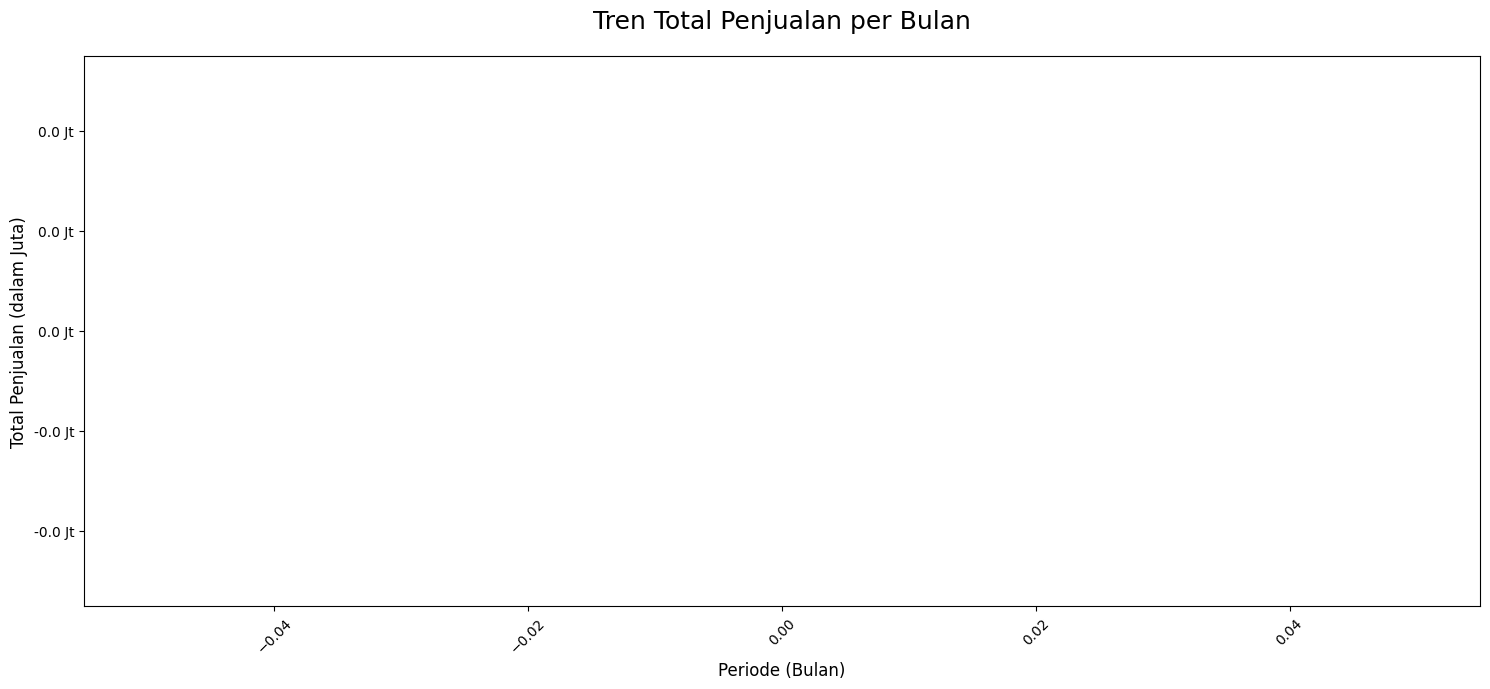

🎉 SUKSES! Grafik telah disimpan sebagai 'tren_penjualan_bulanan.png'.


In [69]:
print("\n\n--- Membangun Data Mart & Visualisasi untuk Tren Penjualan Bulanan ---")

# Transformasi: Tambahkan timestamp laporan
waktu_laporan_dibuat = datetime.now()
df_tren['tgl_laporan'] = waktu_laporan_dibuat
print(f"Menambahkan timestamp laporan: {waktu_laporan_dibuat}")

# Load Hasil Analisis ke Data Mart (`adventureworks_wh`)
target_table_name_tren = 'rpt_tren_penjualan_bulanan'
print(f"Menambahkan data ringkasan baru ke tabel '{target_table_name_tren}' di database '{db_name_wh}'...")
df_tren.to_sql(target_table_name_tren, engine_wh, if_exists='append', index=False)
print(f"✅ Tabel ringkasan '{target_table_name_tren}' berhasil ditambahkan data baru.")

# Visualisasi & Simpan Gambar
print("\nMembuat visualisasi (Line Chart) dan menyimpannya ke folder 'output'...")
plt.figure(figsize=(15, 7))
lineplot = sns.lineplot(x='periode', y='total_penjualan', data=df_tren, marker='o', color='royalblue')
plt.title('Tren Total Penjualan per Bulan', fontsize=18, pad=20)
plt.xlabel('Periode (Bulan)', fontsize=12)
plt.ylabel('Total Penjualan (dalam Juta)', fontsize=12)
plt.xticks(rotation=45)
lineplot.yaxis.set_major_formatter(lambda x, pos: f'{x/1e6:.1f} Jt')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'tren_penjualan_bulanan.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"🎉 SUKSES! Grafik telah disimpan sebagai 'tren_penjualan_bulanan.png'.")

#### Hasil Analisis 3: Top 10 Pelanggan dengan Total Belanja Terbanyak

Data `df_top_cust` akan dimuat ke `adventureworks_wh` dan divisualisasikan sebagai Horizontal Bar Chart

In [70]:
print("\n\n--- Membangun Data Mart & Visualisasi untuk Top 10 Pelanggan ---")

# Transformasi: Tambahkan timestamp laporan
df_top_cust['tgl_laporan'] = datetime.now()
print(f"Menambahkan timestamp laporan: {waktu_laporan_dibuat}")

# Load Hasil Analisis ke Data Mart (`adventureworks_wh`)
target_table_name_top_cust = 'rpt_top_10_pelanggan'
print(f"Menyimpan hasil ringkasan ke tabel '{target_table_name_top_cust}' di database '{db_name_wh}'...")
df_top_cust.to_sql(target_table_name_top_cust, engine_wh, if_exists='append', index=False)
print(f"✅ Tabel ringkasan '{target_table_name_top_cust}' berhasil ditambahkan data baru.")

# Visualisasi & Simpan Gambar
print("\nMembuat visualisasi (Horizontal Bar Chart) dan menyimpannya ke folder 'output'...")
plt.figure(figsize=(12, 8)) # Buat figur sedikit lebih tinggi
barplot = sns.barplot(
    x='total_belanja',
    y='nama_lengkap',
    data=df_top_cust,
    palette='viridis'
)
plt.title('Top 10 Pelanggan dengan Total Belanja Terbanyak', fontsize=18, pad=20)
plt.xlabel('Total Belanja (dalam Ribu)', fontsize=12)
plt.ylabel('Nama Pelanggan', fontsize=12)
barplot.xaxis.set_major_formatter(lambda x, pos: f'{(x/1e3):.0f} Rb')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'top_10_pelanggan.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"🎉 SUKSES! Grafik telah disimpan sebagai 'top_10_pelanggan.png'.")



--- Membangun Data Mart & Visualisasi untuk Top 10 Pelanggan ---


NameError: name 'df_top_cust' is not defined

#### Hasil Analisis 4: Menyimpan laporan dalam warehouse

In [ ]:
if 'df_final_report' in locals():
    # Transformasi: Tambahkan timestamp laporan
    df_final_report['tgl_laporan'] = datetime.now()
    
    # Load Hasil Analisis ke Data Mart (_wh)
    target_table_name = 'rpt_sentimen_vs_penjualan'
    print(f"\nMenyimpan laporan final ke tabel '{target_table_name}'...")
    df_final_report.to_sql(target_table_name, engine_wh, if_exists='append', index=False)
    print(f"✅ Laporan final berhasil disimpan di Data Mart ('{target_table_name}')!")
else:
    print("⚠️ DataFrame 'df_final_report' tidak ditemukan. Jalankan sel analisis terlebih dahulu.")


Menyimpan laporan final ke tabel 'rpt_sentimen_vs_penjualan'...
✅ Laporan final berhasil disimpan di Data Mart ('rpt_sentimen_vs_penjualan')!
